## Notebook 05 — Liquidation Waterfall Over Time (Oracle Lag Along a Price Path)

This notebook extends the one-step liquidation engine into a multi-step time-path simulation, showing how liquidation risk and realized losses evolve during a crash-and-stabilize market regime.

While Notebook 03 measures bad debt under a single stressed snapshot, real protocols liquidate over time as prices move, oracles update, and liquidators execute in rounds. A key real-world failure mode is oracle lag: if the oracle price is stale, positions may not be flagged early enough, allowing debt to become undercollateralized before liquidation starts. This notebook models that gap by separating:
	•	Trigger price = oracle price (possibly lagged)
	•	Execution price = current spot price (used for collateral sale)

The workflow consists of:

	1.	Defining a simple price path (step returns: crash then flat) to imic a short stress episode
	2.	Running a multi-round liquidation waterfall at each time step (bounded by max rounds per step), applying close factor, liquidation bonus, and slippage frictions
	3.	Comparing two scenarios (e.g., oracle_lag = 0 vs 2 steps) to isolate the impact of delayed triggers on outcomes
	4.	Tracking time-series metrics:
	•	liquidatable rate (end-of-step trigger pressure)
	•	bad debt rate (cumulative uncovered loss vs initial total debt)
	•	remaining total debt and remaining collateral value

The resulting time-path curves provide an intuitive view of how oracle latency can amplify tail losses, and serve as a bridge from static stress surfaces (Notebooks 02–03) to more realistic “crash dynamics” behavior useful for policy discussion and protocol risk narratives.

In [ ]:
#1. Imports

!rm -rf b1-defi-risk
!git clone https://github.com/lydialydia-lydia/b1-defi-risk.git
%cd b1-defi-risk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sim_data import generate_synthetic_positions

Cloning into 'b1-defi-risk'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 92 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 428.57 KiB | 14.29 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/b1-defi-risk/b1-defi-risk


In [ ]:
#2. Generate positions
SEED = 42
positions = generate_synthetic_positions(seed=SEED)

price_init = float(positions["collateral_price_init"].iloc[0])
total_debt_init = float(positions["debt_amount"].sum())
print("positions:", positions.shape, "| price_init:", price_init, "| total_debt_init:", total_debt_init)

positions.head()

positions: (10000, 8) | price_init: 2500.0 | total_debt_init: 25542712.62433892


,position_id,collateral_asset,debt_asset,collateral_amount,debt_amount,collateral_price_init,collateral_value_init,target_ltv
0,1,ETH,USD,1.356241,2149.988760,2500.0,3390.603102,0.634102
1,2,ETH,USD,0.353460,611.424356,2500.0,883.650749,0.691930
2,3,ETH,USD,2.117955,2659.190187,2500.0,5294.888534,0.502218
3,4,ETH,USD,2.561427,3824.058498,2500.0,6403.568725,0.597176
4,5,ETH,USD,0.142127,243.865636,2500.0,355.317168,0.686332


In [ ]:
#3. Define a price path (crash then stabilize)
def make_price_path(price0: float, returns: list[float]) -> np.ndarray:
    """
    Build a spot price path from per-step simple returns.
    Using returns makes it easy to tweak the shock magnitude step-by-step.
    Example: r = -0.10 means the price drops 10% in that step.
    """
    prices = [price0]
    for r in returns:
        prices.append(prices[-1] * (1.0 + r))
    return np.array(prices, dtype=float)

# t=0 starts at price_init
# t=1..3: staged drawdown (-10%, -15%, -10%)
# t>=4: stabilize (flat)
returns = [-0.10, -0.15, -0.10, 0.00, 0.00, 0.00]
spot_prices = make_price_path(price_init, returns)

spot_prices

array([2500.  , 2250.  , 1912.5 , 1721.25, 1721.25, 1721.25, 1721.25])

In [ ]:
#4. Core simulator (multi-round waterfall + oracle lag)
def run_liquidation_waterfall_timepath(
    collateral_amount: np.ndarray,
    debt_amount: np.ndarray,
    spot_prices: np.ndarray,
    liquidation_threshold: float = 0.80,
    close_factor: float = 0.50,
    liquidation_bonus: float = 0.08,
    slippage: float = 0.02,
    oracle_lag_steps: int = 0,
    max_rounds_per_step: int = 10,
    eps: float = 1e-12
) -> pd.DataFrame:
    """
    Simulate liquidations over a spot price path (time steps).

    Main idea:
    - Trigger HF with ORACLE price (can be stale / lagged)
    - Liquidate / seize collateral at SPOT price (execution happens now)
    - Allow multiple liquidation rounds within each time step ("waterfall")
    - Bad debt = remaining debt after collateral is depleted

    Notes: debt price = 1, no interest accrual in this model.
    """

    # Copy arrays so do not mutate inputs
    coll = collateral_amount.astype(float).copy()
    debt = debt_amount.astype(float).copy()

    total_debt_init = float(np.sum(debt))

    records = []

    n_steps = len(spot_prices)
    for t in range(n_steps):
        spot = float(spot_prices[t])

        # can only read past prices
        oracle_index = max(0, t - oracle_lag_steps)
        oracle = float(spot_prices[oracle_index])

        # Run up to max_rounds_per_step liquidation rounds
        for _ in range(max_rounds_per_step):
            # Compute HF using oracle price (trigger condition)
            coll_value_oracle = coll * oracle
            hf = (coll_value_oracle * liquidation_threshold) / np.maximum(debt, eps)

            liquidatable = (hf < 1.0) & (debt > eps) & (coll > eps)
            if not np.any(liquidatable):
                break

            # Protocol caps how much debt can be repaid in one liquidation event
            repay_target = close_factor * debt

            # Execution at SPOT: slippage reduces realized value; bonus increases required collateral
            coll_value_spot = coll * spot
            max_repay_by_coll = coll_value_spot * (1.0 - slippage) / (1.0 + liquidation_bonus)

            # Actual repay is limited by both close_factor and available collateral value
            repay = np.where(liquidatable, np.minimum(repay_target, max_repay_by_coll), 0.0)

            # Convert repay into seized collateral (in units of collateral)
            seized_value_spot = repay * (1.0 + liquidation_bonus) / np.maximum(1.0 - slippage, eps)
            seized_collateral = seized_value_spot / np.maximum(spot, eps)

            # Update balances
            debt = debt - repay
            coll = coll - seized_collateral

            debt = np.maximum(debt, 0.0)
            coll = np.maximum(coll, 0.0)

        # After rounds, compute liquidation state and bad debt at this step
        coll_value_spot_end = coll * spot
        hf_spot_end = (coll_value_spot_end * liquidation_threshold) / np.maximum(debt, eps)
        liquidatable_rate = float(np.mean((hf_spot_end < 1.0) & (debt > eps)))

        # Bad debt if collateral is exhausted but debt remains
        bad_debt = np.where((coll <= eps) & (debt > eps), debt, 0.0)
        bad_debt_total = float(np.sum(bad_debt))
        bad_debt_rate = bad_debt_total / total_debt_init

        total_debt_remaining = float(np.sum(debt))
        total_coll_value_remaining = float(np.sum(coll_value_spot_end))

        records.append({
            "t": t,
            "spot_price": spot,
            "oracle_price": oracle,
            "oracle_lag_steps": oracle_lag_steps,
            "liquidatable_rate_end": liquidatable_rate,
            "bad_debt_total": bad_debt_total,
            "bad_debt_rate": bad_debt_rate,
            "total_debt_remaining": total_debt_remaining,
            "total_coll_value_remaining": total_coll_value_remaining,
            "LT": liquidation_threshold,
            "close_factor": close_factor,
            "liq_bonus": liquidation_bonus,
            "slippage": slippage,
            "max_rounds_per_step": max_rounds_per_step
        })

    return pd.DataFrame(records)

In [ ]:
#5. Run scenarios (no lag vs lag)
# Base protocol params
LT = 0.80
CLOSE_FACTOR = 0.50
LIQ_BONUS = 0.08
SLIPPAGE = 0.02
MAX_ROUNDS = 10

coll0 = positions["collateral_amount"].to_numpy()
debt0 = positions["debt_amount"].to_numpy()

# Scenario A: oracle lag = 0
df0 = run_liquidation_waterfall_timepath(
    collateral_amount=coll0,
    debt_amount=debt0,
    spot_prices=spot_prices,
    liquidation_threshold=LT,
    close_factor=CLOSE_FACTOR,
    liquidation_bonus=LIQ_BONUS,
    slippage=SLIPPAGE,
    oracle_lag_steps=0,
    max_rounds_per_step=MAX_ROUNDS
)

# Scenario B: oracle lag = 2 steps
df2 = run_liquidation_waterfall_timepath(
    collateral_amount=coll0,
    debt_amount=debt0,
    spot_prices=spot_prices,
    liquidation_threshold=LT,
    close_factor=CLOSE_FACTOR,
    liquidation_bonus=LIQ_BONUS,
    slippage=SLIPPAGE,
    oracle_lag_steps=2,
    max_rounds_per_step=MAX_ROUNDS
)


In [ ]:
# Quick sanity check: only show key columns + first few rows
cols = ["t","spot_price","oracle_price","liquidatable_rate_end","bad_debt_rate",
        "total_debt_remaining","total_coll_value_remaining"]

display(df0[cols].head(8))
display(df2[cols].head(8))

# One-line comparison at the end of the path
summary = pd.DataFrame({
    "oracle_lag": [0, 2],
    "final_bad_debt_rate": [df0["bad_debt_rate"].iloc[-1], df2["bad_debt_rate"].iloc[-1]],
    "final_liquidatable_rate_end": [df0["liquidatable_rate_end"].iloc[-1], df2["liquidatable_rate_end"].iloc[-1]],
})
display(summary)

,t,spot_price,oracle_price,liquidatable_rate_end,bad_debt_rate,total_debt_remaining,total_coll_value_remaining
0,0,2500.00,2500.00,0.0001,0.000003,2.531309e+07,4.085467e+07
1,1,2250.00,2250.00,0.0001,0.000003,2.338152e+07,3.464054e+07
2,2,1912.50,1912.50,0.0983,0.001817,1.377607e+07,1.885886e+07
3,3,1721.25,1721.25,0.0982,0.001818,7.788762e+06,1.037471e+07
4,4,1721.25,1721.25,0.0982,0.001818,7.788762e+06,1.037471e+07
5,5,1721.25,1721.25,0.0982,0.001818,7.788762e+06,1.037471e+07
6,6,1721.25,1721.25,0.0982,0.001818,7.788762e+06,1.037471e+07


,t,spot_price,oracle_price,liquidatable_rate_end,bad_debt_rate,total_debt_remaining,total_coll_value_remaining
0,0,2500.00,2500.00,0.0001,0.000003,2.531309e+07,4.085467e+07
1,1,2250.00,2500.00,0.1127,0.000003,2.531309e+07,3.676921e+07
2,2,1912.50,2500.00,0.5429,0.000003,2.531309e+07,3.125383e+07
3,3,1721.25,2250.00,0.8126,0.021914,2.254495e+07,2.507784e+07
4,4,1721.25,1912.50,0.8126,0.046844,1.199060e+07,1.344652e+07
5,5,1721.25,1721.25,0.4802,0.046847,7.577629e+06,8.583238e+06
6,6,1721.25,1721.25,0.4802,0.046847,7.577629e+06,8.583238e+06


,oracle_lag,final_bad_debt_rate,final_liquidatable_rate_end
0,0,0.001818,0.0982
1,2,0.046847,0.4802


In [ ]:
#save table
import os
os.makedirs("artifacts/tables", exist_ok=True)
summary.to_csv("artifacts/tables/05_oracle_lag_summary.csv", index=False)

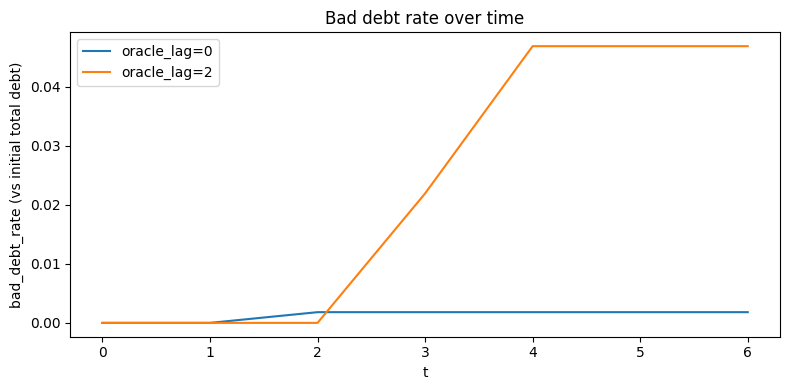

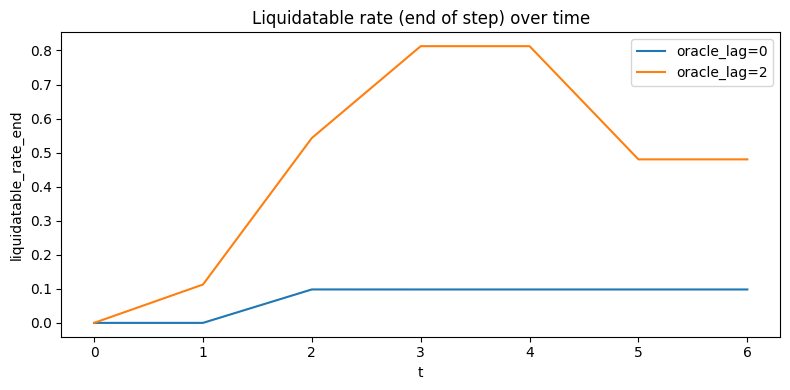

In [ ]:
#6.  Plot time series (bad debt + liquidatable rate)
plt.figure(figsize=(8, 4))
plt.plot(df0["t"], df0["bad_debt_rate"], label="oracle_lag=0")
plt.plot(df2["t"], df2["bad_debt_rate"], label="oracle_lag=2")
plt.title("Bad debt rate over time")
plt.xlabel("t")
plt.ylabel("bad_debt_rate (vs initial total debt)")
plt.legend()
plt.tight_layout()

#save figure
import os
os.makedirs("artifacts/figures", exist_ok=True)
plt.savefig("artifacts/figures/05_bad_debt_over_time.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df0["t"], df0["liquidatable_rate_end"], label="oracle_lag=0")
plt.plot(df2["t"], df2["liquidatable_rate_end"], label="oracle_lag=2")
plt.title("Liquidatable rate (end of step) over time")
plt.xlabel("t")
plt.ylabel("liquidatable_rate_end")
plt.legend()
plt.tight_layout()
#save figure
plt.savefig("artifacts/figures/05_liquidatable_rate_over_time.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
# quick sanity check
assert np.all(np.diff(df0["bad_debt_rate"]) >= -1e-12)
assert np.all(np.diff(df2["bad_debt_rate"]) >= -1e-12)

print("Final bad_debt_rate | lag=0:", float(df0["bad_debt_rate"].iloc[-1]))
print("Final bad_debt_rate | lag=2:", float(df2["bad_debt_rate"].iloc[-1]))
print("lag=2 >= lag=0 ?", bool(df2["bad_debt_rate"].iloc[-1] >= df0["bad_debt_rate"].iloc[-1] - 1e-12))
print("lag=2 >= lag=0 ?", df2["bad_debt_rate"].iloc[-1] >= df0["bad_debt_rate"].iloc[-1] - 1e-12)

Final bad_debt_rate | lag=0: 0.0018176885979975376
Final bad_debt_rate | lag=2: 0.04684658721465433
lag=2 >= lag=0 ? True
lag=2 >= lag=0 ? True
